Денис Иванов

Домашняя работа

Элементарные алгоритмы обработки временных рядов

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from scipy.stats import boxcox

from scipy.optimize import minimize, differential_evolution
from sklearn.metrics import mean_squared_error

from warnings import filterwarnings 
filterwarnings('ignore')

In [3]:
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing  = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest   = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

## Динамика среднемесячной температуры

In [58]:
mean_monthly_temp

,Month,Deg
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1
...,...,...
235,1939-08,61.8
236,1939-09,58.2
237,1939-10,46.7
238,1939-11,46.6


In [59]:
mean_monthly_temp_series = mean_monthly_temp.Deg

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


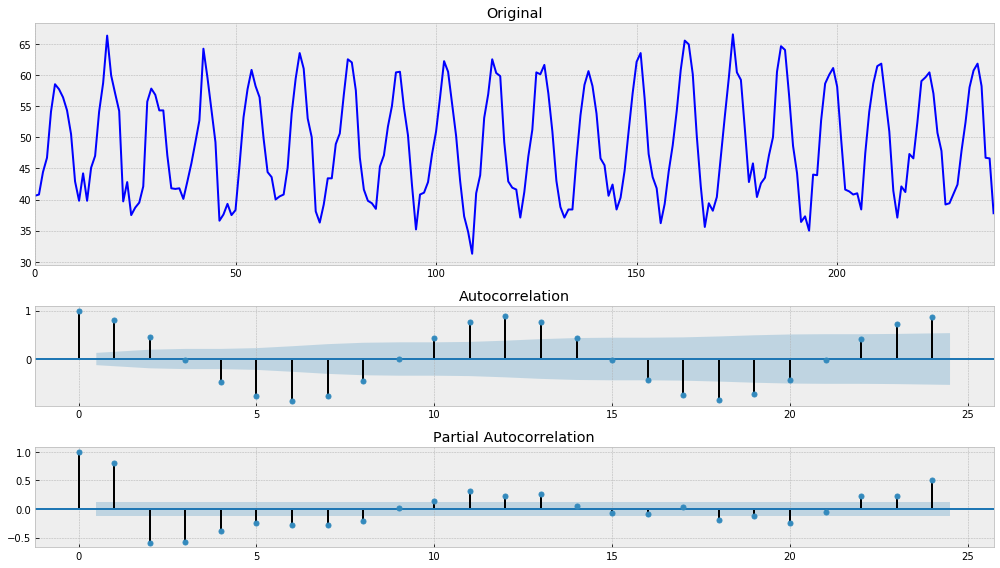

In [60]:
tsplot(mean_monthly_temp_series)

Среднемесячная температура - это всегда сезонность + небольшой долгосрочный тренд (который мы скорее всего не увидим- мало лет). Применим модель Хольта Винтерса

In [61]:
def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [62]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [63]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [103]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',linewidth='1', label='original')
        plt.plot(tema,        color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

Если параменты подобраны вручную:

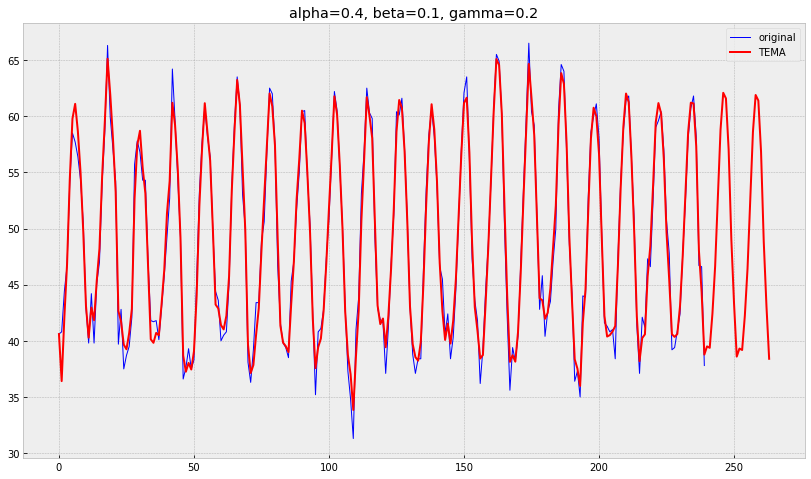

In [109]:
plot_tema(0.4, 0.1, 0.2, ser=mean_monthly_temp_series, ser_to_plot=mean_monthly_temp_series)

При применении методов оптимизации, получаем:

In [111]:
train, test, val = mean_monthly_temp_series[:200], mean_monthly_temp_series[200:226], mean_monthly_temp_series[226:]

In [112]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [113]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [114]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 3.110690498709963
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.15463195e-06,  1.21095699e+01, -1.95399252e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 104
      nit: 20
   status: 0
  success: True
        x: array([0.78823818, 0.        , 0.1228799 ])


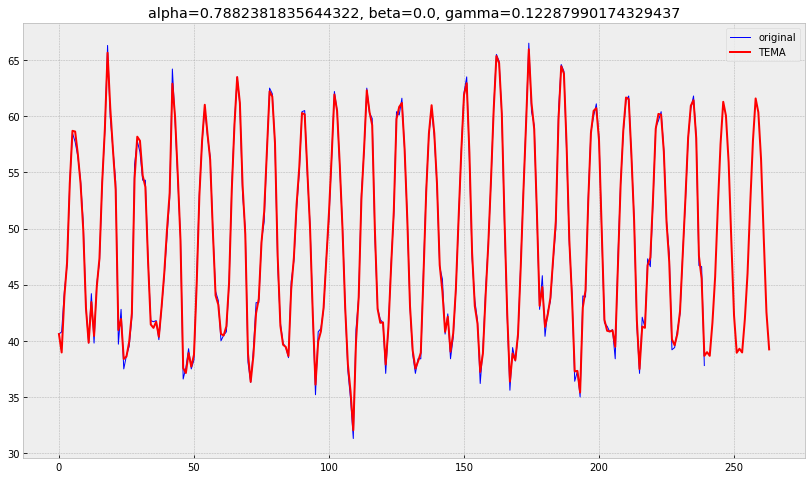

In [117]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=mean_monthly_temp_series, ser_to_plot=mean_monthly_temp_series)

Попробуем применить преобразование Бокса - Кокса и немножко его оптимизировать

In [ ]:
mean_monthly_temp_series_2 = boxcox(mean_monthly_temp_series)

In [97]:
p_val_min = 999
p_val_ind = 0
p_val_lmb = 0

for i in range (1,36):
    adftest   = adfuller(mean_monthly_temp_series_2[0][i:] - mean_monthly_temp_series_2[0][:-i], autolag='AIC')[1]
    if adftest < p_val_min:
        p_val_min = adftest
        p_val_ind = i
        p_val_lmb = mean_monthly_temp_series_2[1]
        
print('Наименьшее значение p value = ', p_val_min, 
      'достигается при лямбде = ', round (p_val_lmb, 2), 
      'и сдвиге в ', p_val_ind, 'месяцев') 

Наименьшее значение p value =  1.5594734603236314e-22 достигается при лямбде =  0.07 и сдвиге в  1 месяцев


Results of Dickey-Fuller Test:
Test Statistic                -1.215240e+01
p-value                        1.559473e-22
#Lags Used                     1.100000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


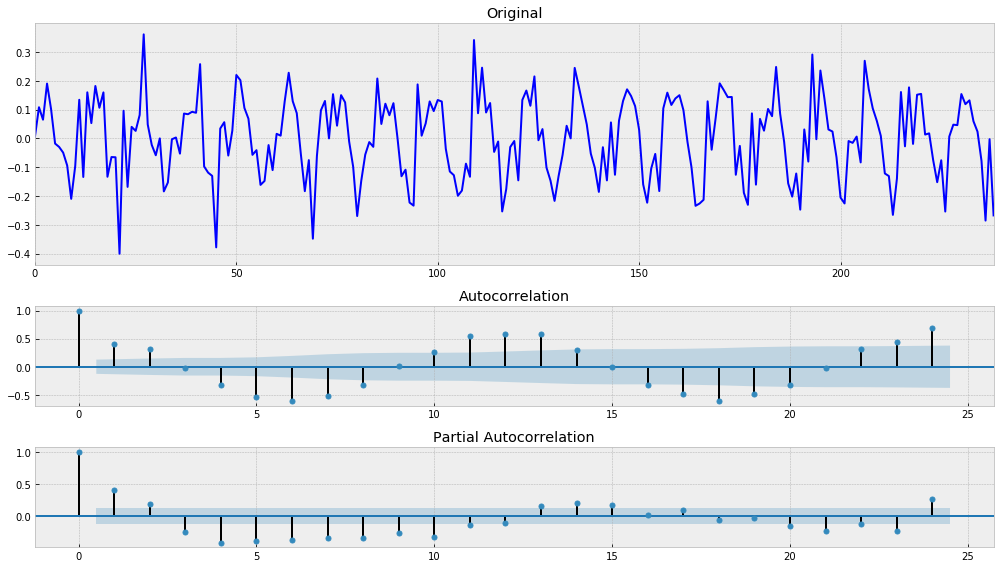

In [101]:
tsplot(mean_monthly_temp_series_2[0][1:] - mean_monthly_temp_series_2[0][:-1])

In [102]:
mean_monthly_temp_series_2 = boxcox(mean_monthly_temp_series, 0.07)

In [118]:
train, test, val = mean_monthly_temp_series_2[:200], mean_monthly_temp_series_2[200:226], mean_monthly_temp_series_2[226:]

In [119]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [120]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.0027220038696039103
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.48520169e-06,  6.95131179e-03,  1.81482433e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 84
      nit: 14
   status: 0
  success: True
        x: array([0.79883873, 0.        , 0.10396065])


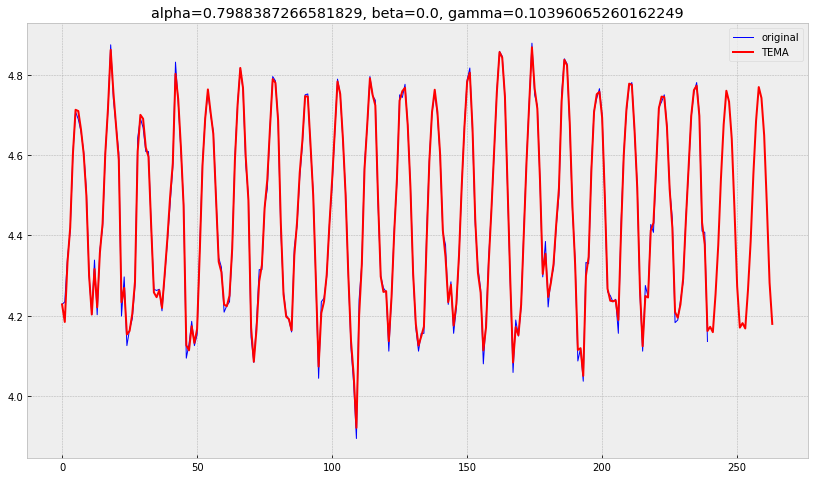

In [121]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=mean_monthly_temp_series_2, ser_to_plot=mean_monthly_temp_series_2)

Высокая предсказательная способность модели обусловлена высокой предсказуемостью исходных данных (среднемесячная температура воздуха) и сезонного их характера 

## Индекс Доу Джонса

In [123]:
dowjones_series = dowjones_closing.Close
dowjones_series

0      890.19
1      901.80
2      888.51
3      887.78
4      858.43
        ...  
157    791.77
158    787.23
159    787.94
160    784.57
161    752.58
Name: Close, Length: 162, dtype: float64

Сезонности в индексе Доу Джонса точно нет (по экономической сути да и по графику), пробуем экспоненциальное сглаживание

In [125]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

Подберем параметры экспоненциального сглаживания, обеспечивающие минимальную средне квадратическую ошибку

Что то мне подсказывает, что minimiz`ом здесь не обойдешься, попробуем более сложный инструмент оптимизации

In [ ]:
bounds = [(0, 20), (0, 20), (0, 20), (0, 20), (0, 20)]

In [140]:
def mse_100(params):
    error = mean_squared_error(weighted_moving_average(dowjones_series, 5, 
                                                       [params[0],params[1],params[2],params[3],params[4]]
                                                       )[100:], 
                               dowjones_series[100:])
    return error

In [148]:
result_100 = differential_evolution(mse_100, bounds, maxiter = 100000, strategy= 'randtobest1bin')

result_100

     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 2879706
     nit: 38395
 success: True
       x: array([ 0.        ,  0.        ,  0.        ,  0.        , 17.52788902])

In [159]:
mean_squared_error(weighted_moving_average(dowjones_series, 5, 
                                                       [ 0,  0,  0,  0, 17.52788902]
                                                       )[5:], 
                   dowjones_series[5:])

2.222718604591137e-27

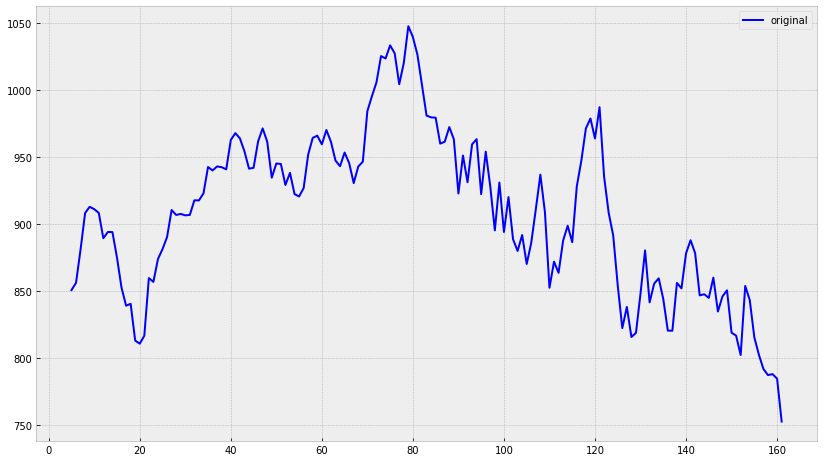

In [160]:
test_ema_dowjones = weighted_moving_average(dowjones_series, 5, [ 0,  0,  0,  0, 17.52788902])[5:]


with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(dowjones_series[5:], color='blue',label='original')
    # plt.plot(test_ema_dowjones,    color='red', linewidth='2', label='EMA')
    plt.legend()

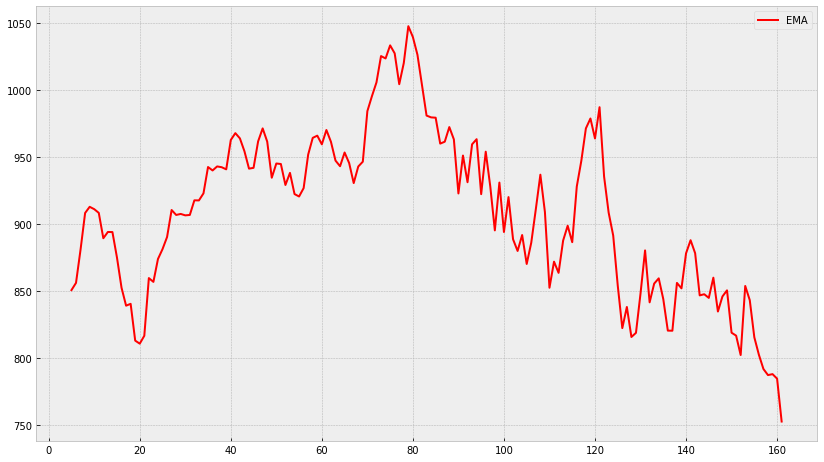

In [161]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(test_ema_dowjones,    color='red', linewidth='2', label='EMA')
    plt.legend()

Очень похоже на искусственно сгенерированные данные, не верю, что Доу Джонс может быть настолько предсказуем